In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [96]:
# Open and read the text file
with open('ex4data.txt', 'r') as file:
    lines = file.readlines()

# Split each line by commas and create a list of lists
split_data = [line.strip().split(',') for line in lines]

# Convert the split data into a list of tuples with numeric values
numeric_data = [(float(row[0]), float(row[1]), float(row[2])) for row in split_data]

# Specify column names
column_names = ['x1', 'x2', 'y']

# Create a Polars DataFrame with specified schema
data = pl.DataFrame(numeric_data, schema=[(col, pl.Float64) for col in column_names], orient="row")

columns = data.columns
n = len(columns)-1
m  = len(data)
x = data.select(columns[:n])
y = data.select(columns[-1])

In [31]:
x.shape

(100, 2)

Text(0.5, 1.0, 'Scatter plot of x1 vs x2 colored by y')

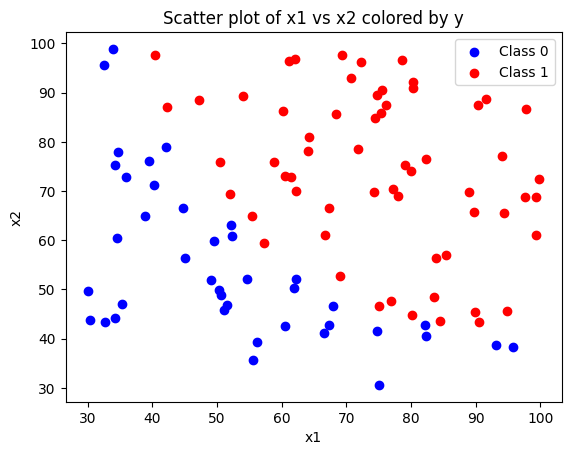

In [97]:
x1 = data['x1'].to_list()
x2 = data['x2'].to_list()
y_list = data['y'].to_list()

plt.figure()
plt.scatter([x1[i] for i in range(len(y_list)) if y_list[i] == 0], [x2[i] for i in range(len(y_list)) if y_list[i] == 0], color='blue', label='Class 0')
plt.scatter([x1[i] for i in range(len(y_list)) if y_list[i] == 1], [x2[i] for i in range(len(y_list)) if y_list[i] == 1], color='red', label='Class 1')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Scatter plot of x1 vs x2 colored by y')

In [117]:
mean_x = x.mean()
std_x = x.std()
standardized_x = x.with_columns([(pl.col(col) - mean_x[col]) / std_x[col] for col in columns[:n]])
standardized_x = standardized_x.with_columns(pl.lit(1).alias("constant"))
standardized_x = standardized_x.select(["constant"] + [col for col in standardized_x.columns if col != "constant"])
x_mat = standardized_x.to_numpy().reshape(-1, n+1).T
y_mat = y.to_numpy().reshape(-1, 1)


[[1.71664355]
 [4.00902327]
 [3.74014941]]


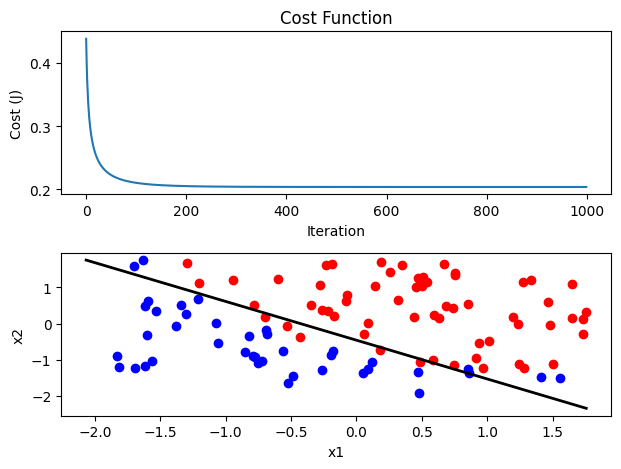

In [114]:
theta = np.random.rand(n+1, 1)
H = 1 / (1 + np.exp(-np.dot(theta.T, x_mat))).T
alpha = 1
loop = 1000
J_values = np.zeros((loop, 1))
for i in range(loop):
    theta = theta - (alpha/m)*np.dot(x_mat, (H-y_mat))
    H = 1 / (1 + np.exp(-np.dot(theta.T, x_mat))).T
    J_values[i] = 1/(m)*(-np.dot(y_mat.T, np.log(H))-np.dot(1-y_mat.T, np.log(1-H)))

print(theta)

x2_points = ((-theta[0]-theta[1]*standardized_x['x1'].max())/theta[2])[0]
x1_points = ((-theta[0]-theta[2]*standardized_x['x2'].max())/theta[1])[0]

standardized_data = standardized_x.with_columns(y)

# Create a figure and a set of subplots
fig, axs = plt.subplots(2)
# Plot the cost function on the first subplot
axs[0].plot(J_values)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Cost (J)')
axs[0].set_title('Cost Function')

axs[1].scatter([standardized_data['x1'][i] for i in range(len(standardized_data)) if standardized_data['y'][i] == 0], [standardized_data['x2'][i] for i in range(len(standardized_data)) if standardized_data['y'][i] == 0], color='blue', label='Class 0')
axs[1].scatter([standardized_data['x1'][i] for i in range(len(standardized_data)) if standardized_data['y'][i] == 1], [standardized_data['x2'][i] for i in range(len(standardized_data)) if standardized_data['y'][i] == 1], color='red', label='Class 1')
axs[1].plot([x1_points, standardized_x['x2'].max()], [standardized_x['x1'].max(), x2_points], color='black', linestyle='-', linewidth=2, label='Line')
axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')

# Layout so plots do not overlap
fig.tight_layout()